In [ ]:
from google.colab import drive
drive.mount('/content/drive'  , force_remount=True
)

Mounted at /content/drive


In [ ]:
ROOT_DIR = '/content/drive/MyDrive/GolfDB/train_yolo_model/code'

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 10.9 MB/s eta 0:00:00


In [ ]:
import os
import torch

from ultralytics import YOLO

# Set cuDNN to deterministic mode for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load a model
model = YOLO("yolov8n.pt")  # build a model with pre-trained weights

# Use the model
model_results = model.train(data=os.path.join(ROOT_DIR, "config.yml"), epochs=150,
                            pretrained=True, lr0 = 0.01, patience=10, imgsz=1024)

100%|██████████| 6.23M/6.23M [00:00<00:00, 279MB/s]
Ultralytics YOLOv8.0.147 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/GolfDB/train_yolo_model/code/config.yml, epochs=150, patience=10, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

In [ ]:
import shutil

shutil.copytree('/content/runs', '/content/drive/MyDrive/GolfDB/train_yolo_model/code/runs_pretrained_10')

'/content/drive/MyDrive/GolfDB/train_yolo_model/code/runs_pretrained_10'

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
#!pip install ultralytics
!pip install numpy scipy opencv-python torch torchvision tensorflow
!pip install deep-sort-realtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.1 MB/s eta 0:00:00


In [ ]:
!ls

drive  runs  sample_data  yolov8n.pt


In [ ]:
video_path = "/content/drive/MyDrive/GolfDB/swing_video_files/face_on_official/IMG_2174.MOV"

In [ ]:
import os
import random

import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

import pandas as pd

# Initialize an empty list to hold detection data
detection_data = []

tracker = DeepSort(max_age=5) #, embedder="clip_ViT-B/16")

cap = cv2.VideoCapture(video_path)

# Add a frame counter
frame_counter = 0

ret, frame = cap.read()

# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# cap_out = cv2.VideoWriter('/content/output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (frame.shape[1], frame.shape[0]))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (frame.shape[1], frame.shape[0])
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'FourCC code: mp4v')
print(f'Frame rate: {fps}')
print(f'Frame size: {frame_size}')
print(f'# Frames: {num_frames}')
print(video_path)

cap_out = cv2.VideoWriter('/content/output.mp4', fourcc, 30, frame_size)


model = YOLO("/content/drive/MyDrive/GolfDB/train_yolo_model/code/runs_pretrained_10/detect/train/weights/best.pt")

colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for j in range(10)]

detection_threshold = 0.1

while cap.isOpened():
  ret, frame = cap.read()

  # if there are no more frames break the loop
  if not ret:
    break

  # Only process certain frames
  if 950 <= frame_counter <= 960:
    results = model(frame)

    for result in results:
        detections = []
        for r in result.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = r
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            class_id = int(class_id)
            if score > detection_threshold:
              detections.append(([x1, y1, x2-x1, y2-y1], score, class_id))
        tracks = tracker.update_tracks(detections, frame=frame)

        for track in tracks:
          if not track.is_confirmed():
            continue
          bbox = track.to_ltrb()
          track_id = track.track_id
          track_id = int(track_id)
          cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (colors[track_id % len(colors)]), 3)

          # Add detection data to the list as a dictionary
          detection_data.append({'frame': frame_counter, 'x1': bbox[0], 'y1': bbox[1], 'x2': bbox[2], 'y2': bbox[3], 'track_id': track_id, 'class_id': class_id, 'score': score})

  frame_counter += 1 # increment frame counter

cap.release()
#cap_out.release()
cv2.destroyAllWindows()

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(detection_data)

FourCC code: mp4v
Frame rate: 239.69072164948454
Frame size: (1080, 1920)
# Frames: 2015
/content/drive/MyDrive/GolfDB/swing_video_files/first_try/Copy of IMG_2275.MOV



0: 1024x576 2 golf balls, 1 golf club, 53.5ms
Speed: 9.8ms preprocess, 53.5ms inference, 29.6ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x576 2 golf balls, 1 golf club, 9.2ms
Speed: 5.1ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x576 2 golf balls, 1 golf club, 9.3ms
Speed: 4.7ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x576 2 golf balls, 1 golf club, 9.2ms
Speed: 4.5ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x576 2 golf balls, 1 golf club, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x576 2 golf balls, 1 golf club, 9.2ms
Speed: 6.2ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 576)

0: 1024x576 2 golf balls, 1 golf club, 9.3ms
Speed: 6.8ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 5

In [ ]:
df.head(30)

,frame,x1,y1,x2,y2,track_id,class_id,score
0,952,519.154743,834.779555,549.624812,865.220445,2,0,0.800716
1,952,159.000000,738.000000,177.000000,756.000000,3,0,0.800716
2,953,519.638456,835.101825,549.463368,864.898175,2,1,0.789079
3,953,159.000000,738.000000,177.000000,756.000000,3,1,0.789079
4,954,520.122169,835.424094,549.301925,864.575906,2,0,0.807215
5,954,159.000000,738.000000,177.000000,756.000000,3,0,0.807215
6,955,520.605882,835.746363,549.140481,864.253637,2,0,0.806907
7,955,159.000000,738.000000,177.000000,756.000000,3,0,0.806907
8,956,521.089595,836.068633,548.979038,863.931367,2,0,0.755647
9,956,159.000000,738.000000,177.000000,756.000000,3,0,0.755647


In [ ]:
!ls /content

sample_data


In [ ]:
mask = df.groupby('frame')['class_id'].apply(lambda x: ((x == 32) | (x == 34) | (x == 38) | (x == 36)).any())
first_frame_without_class_id_32 = mask.idxmin()
#print(first_frame_without_class_id_32)
# first ten frames without
frames_without_class_id_1 = mask[mask == False].index[:10]
print(frames_without_class_id_1)

Int64Index([227, 228, 229, 231, 232, 233, 234, 236, 239, 247], dtype='int64', name='frame')


In [ ]:
video_path = "/content/drive/MyDrive/GolfDB/swing_video_files/first_try/Copy of IMG_7991.MOV"

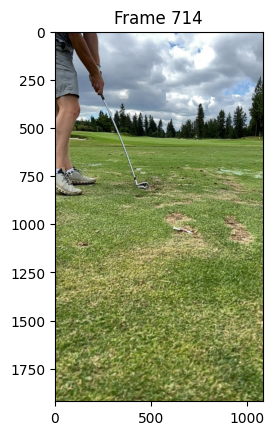

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the original video
cap = cv2.VideoCapture(video_path)

# Initialize frame counter
frame_counter = 0

# Desired frame
desired_frame = 714

while cap.isOpened():
    ret, frame = cap.read()

    # If there are no more frames break the loop
    if not ret:
        break

    if frame_counter == desired_frame:
        # Convert the colorspace from BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        plt.imshow(frame)
        plt.title(f'Frame {frame_counter}')
        plt.show()

        # Can break the loop here if done processing frames
        break

    frame_counter += 1  # increment frame counter

cap.release()

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the original video
c = cv2.VideoCapture(video_path)

# Set the frame to be read next
c.set(cv2.CAP_PROP_POS_FRAMES, 1160)

# Read the frame
ret, frame = c.read()

# If the frame was read correctly ret is True
if ret:
    # Convert the colorspace from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame using matplotlib
    plt.imshow(frame)
    plt.title('Frame 1060')
    plt.show()
else:
    print('no')

c.release()

no


In [ ]:
df[(df['frame'] > 948) & (df['frame'] < 955)]

,frame,x1,y1,x2,y2,track_id,class_id,score
907,949,517.999796,834.000000,550.000204,866.000000,2,0,0.698085
908,949,158.789768,738.000000,175.868346,755.087656,3,0,0.698085
909,950,517.999796,834.000000,550.000204,866.000000,2,0,0.804878
910,950,158.923122,738.000000,176.581542,755.666908,3,0,0.804878
911,951,517.999796,834.000000,550.000204,866.000000,2,0,0.807381
912,951,158.972229,738.000000,176.844957,755.880497,3,0,0.807381
913,952,518.942239,834.660815,549.718576,865.339185,2,0,0.800716
914,952,158.991267,738.000000,176.947110,755.962901,3,0,0.800716
915,953,519.051634,834.733615,549.681980,865.266385,2,1,0.789079
916,953,158.998475,738.000000,176.985897,755.993815,3,1,0.789079


In [ ]:
df.head(30)

,frame,x1,y1,x2,y2,track_id,class_id,score
0,502,322.468354,1.0,692.343995,833.000000,1,0,0.322317
1,502,509.000000,834.0,540.000000,869.000000,2,0,0.322317
2,502,128.000000,1406.0,156.000000,1485.000000,3,0,0.322317
3,503,322.312030,1.0,692.043069,833.000000,1,0,0.343275
4,503,509.000000,834.0,540.000000,869.000000,2,0,0.343275
5,503,128.000000,1406.0,156.000000,1485.000000,3,0,0.343275
6,504,323.040915,1.0,692.603410,833.000000,1,0,0.338442
7,504,509.000000,834.0,540.000000,869.000000,2,0,0.338442
8,504,128.000000,1406.0,156.000000,1485.000000,3,0,0.338442
9,505,323.726113,1.0,693.050041,833.000000,1,0,0.339636


In [ ]:
df.describe()

,frame,x1,y1,x2,y2,track_id,class_id,score
count,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000
mean,980.114448,294.442199,547.548323,506.495571,960.401467,15.095373,4.660308,0.447807
std,321.374596,204.736902,620.080657,262.897377,385.949797,24.558518,11.573744,0.255994
min,502.000000,-902.200241,-105.676408,81.805841,41.323579,1.000000,0.000000,0.250019
25%,709.000000,127.932319,0.998021,156.167063,823.956203,1.000000,0.000000,0.281853
50%,895.000000,313.948581,36.105196,540.259421,838.000806,2.000000,0.000000,0.316093
75%,1253.250000,413.275259,1405.997506,714.752885,1484.913368,9.250000,0.000000,0.476115
max,1607.000000,1000.523374,1407.220822,1603.786027,1488.072056,84.000000,38.000000,0.955171


In [ ]:
df[(df['frame'] > 945) & (df['frame'] < 965)]

,frame,x1,y1,x2,y2,track_id,class_id,score
901,946,517.999796,834.000000,550.000204,866.000000,2,1,0.360081
902,946,158.999976,738.000000,177.000024,756.000000,3,1,0.360081
903,947,517.999796,834.000000,550.000204,866.000000,2,0,0.804812
904,947,158.999976,738.000000,177.000024,756.000000,3,0,0.804812
905,948,517.999796,834.000000,550.000204,866.000000,2,0,0.816048
906,948,159.281725,738.000000,176.718275,755.339185,3,0,0.816048
907,949,517.999796,834.000000,550.000204,866.000000,2,0,0.698085
908,949,158.789768,738.000000,175.868346,755.087656,3,0,0.698085
909,950,517.999796,834.000000,550.000204,866.000000,2,0,0.804878
910,950,158.923122,738.000000,176.581542,755.666908,3,0,0.804878


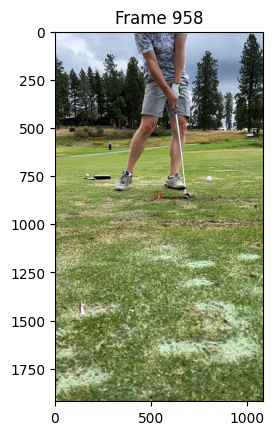

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the original video
c = cv2.VideoCapture(video_path)

# Set the frame to be read next
c.set(cv2.CAP_PROP_POS_FRAMES, 955)

# Read the frame
ret, frame = c.read()

# If the frame was read correctly ret is True
if ret:
    # Convert the colorspace from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Define bounding box coordinates, e.g., (x1, y1, x2, y2)
    bbox = (518.584638,	832.632841,	550.415362,	866.000249		)

    # Convert the bbox values to integers
    bbox = tuple(map(int, bbox))

    # Draw the bounding box on the frame
    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

    # Display the frame using matplotlib
    plt.imshow(frame)
    plt.title('Frame 958')
    plt.show()
else:
    print('Could not read frame 958')

c.release()

In [ ]:
# count frequency
combination_counts = df.groupby(['track_id', 'class_id']).size().reset_index(name='counts')

In [ ]:
most_frequent_combination = combination_counts.groupby('track_id')['counts'].idxmax()
frequent_objects = combination_counts.loc[most_frequent_combination]

In [ ]:
print(combination_counts)
print(most_frequent_combination)
print(frequent_objects)

    track_id  class_id  counts
0          1         0     718
1          1         1      37
2          3         0       5
3          3         1       2
4          4         0     374
5          4         1       8
6          5         0      20
7          5         1       1
8          8         0     300
9          8         1      25
10        10         0       7
11        10         1       6
12        11         0      35
13        12         0      16
14        14         0      11
15        15         0      12
16        17         0      56
17        17         1       2
18        34         0     305
19        36         0     117
20        36         1       7
21        38         0      67
22        38         1     135
23        39         0      59
24        39         1       5
25        44         1      63
26        45         1      16
27        48         0       3
28        48         1      34
29        49         0       3
30        49         1      18
31      

In [ ]:
combination_counts_2 = df.groupby(['class_id', 'track_id']).size().reset_index(name='counts')
most_frequent_combination_2 = combination_counts.groupby('class_id')['counts'].idxmax()
frequent_objects_2 = combination_counts.loc[most_frequent_combination]

print(combination_counts_2)
print(most_frequent_combination_2)
print(frequent_objects_2)

    class_id  track_id  counts
0          0         1     786
1          0         2       8
2          0         3       1
3          0         6       6
4          0         7       7
5          0        12       2
6          0        13       3
7          0        25       6
8          0        30       9
9          0        33       3
10         0        34       5
11         0        35       9
12        13         1       1
13        13         2       1
14        29         1       1
15        32         1     356
16        32         2     198
17        32         3       5
18        32         6      32
19        32         7       4
20        32        12       3
21        32        13     105
22        32        14       7
23        32        25       4
24        32        30       2
25        35         1       5
26        36         1      36
27        36        33      15
28        36        34       2
29        36        35      11
30        38         1      29
31      

In [ ]:
df['track_id'].value_counts()

1     1214
2      207
13     110
6       38
25      28
35      20
33      18
7       11
30      11
14       8
34       7
3        6
12       6
Name: track_id, dtype: int64

In [ ]:
df[df['frame'] == 958]

,frame,x1,y1,x2,y2,track_id,class_id,score
842,958,303.038256,-0.001168,715.35583,836.899033,1,0,0.928336


In [ ]:
df[(df['frame'] > 945) & (df['frame'] < 965)]

,frame,x1,y1,x2,y2,track_id,class_id,score
1566,946,519.138361,835.000000,549.841504,865.000000,1,0,0.766457
1567,947,519.125272,835.000000,549.856969,865.000000,1,1,0.732985
1568,948,519.113403,835.000000,549.870938,865.000000,1,0,0.364237
1569,949,519.102639,835.000000,549.883554,865.000000,1,0,0.309159
1570,950,519.471130,835.000000,550.177511,865.000000,1,0,0.252774
1571,950,158.609049,736.682417,177.687971,756.870497,17,0,0.252774
1572,951,519.251735,835.000000,549.986362,865.000000,1,0,0.259131
1573,951,158.955885,736.907823,177.091039,756.095520,17,0,0.259131
1574,952,519.252756,835.000000,549.987566,865.000000,1,1,0.599671
1575,952,159.147079,736.912091,176.762324,755.549703,17,1,0.599671


In [ ]:
df[(df['frame'] > 740) & (df['frame'] < 765)]

,frame,x1,y1,x2,y2,track_id,class_id,score
478,741,344.429714,1.000000,666.841643,834.838862,1,32,0.765274
479,741,516.865057,834.999266,549.131535,868.014761,2,32,0.765274
480,742,344.824239,1.000000,667.512192,833.848534,1,32,0.765752
481,742,516.878173,834.999353,549.118823,868.013014,2,32,0.765752
482,743,344.523624,1.000000,667.558213,832.862906,1,32,0.763609
483,743,516.890015,834.999429,549.107336,868.011473,2,32,0.763609
484,744,344.589617,1.000000,668.062656,832.540378,1,32,0.752983
485,744,516.900708,834.999497,549.096957,868.010114,2,32,0.752983
486,745,344.458379,1.000000,668.412212,832.465212,1,32,0.734150
487,745,516.910363,834.999556,549.087579,868.008917,2,32,0.734150


In [ ]:
df.head()

,frame,x1,y1,x2,y2,track_id,class_id,score
0,502,341.619138,1.0,674.193211,829.220445,1,32,0.697191
1,502,518.000000,836.0,549.000000,869.000000,2,32,0.697191
2,503,342.413817,1.0,674.467973,828.212305,1,32,0.695662
3,503,517.940424,836.0,548.296325,868.236749,2,32,0.695662
4,504,342.553686,1.0,674.630138,828.646971,1,32,0.691951


In [ ]:
mask = df.groupby('frame')['class_id'].apply(lambda x: ((x == 32) | (x == 34) | (x == 38) | (x == 36)).any())
first_frame_without_class_id_32 = mask.idxmin()
#print(first_frame_without_class_id_32)
# first ten frames without
frames_without_class_id_1 = mask[mask == False].index[:10]
print(frames_without_class_id_1)

Int64Index([916, 917, 920, 921, 922, 923, 924, 925, 926, 927], dtype='int64', name='frame')
